In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Preparazione dati e filtraggio match International, International Gold, Masters, Masters Cup

In [157]:
# Caricamento dati
df = pd.read_csv('Datasets/atp_tennis.csv')

# Salva il numero originale di righe
original_rows = len(df)

# Filtra ranking e punti negativi o nulli
rows_before = len(df)
df = df[
    (df['Rank_1'] > 0) & 
    (df['Rank_2'] > 0) & 
    (df['Pts_1'] > 0) & 
    (df['Pts_2'] > 0)
]
rows_after = len(df)
print(f"\nRighe rimosse per ranking o punti non validi: {rows_before - rows_after}")

# Mostra distribuzione originale delle categorie
print("\nDistribuzione originale delle categorie dei tornei:")
print(df['Series'].value_counts())
print("\nDistribuzione originale dei Round:")
print(df['Round'].value_counts())

# Filtra le categorie non rilevanti dal target
rows_before_series = len(df)
df = df[~df['Series'].isin(['International', 'International Gold', 'Masters', 'Masters Cup'])]
rows_after_series = len(df)

print(f"\nRighe rimosse dal filtraggio delle Series: {rows_before_series - rows_after_series}")
print("Categorie rimosse:")
for category in ['International', 'International Gold', 'Masters', 'Masters Cup']:
    count = len(df[df['Series'] == category])
    print(f"- {category}: {count} partite")

# Mostra distribuzione delle categorie dopo il filtraggio delle Series
print("\nDistribuzione delle categorie dei tornei dopo il filtraggio delle Series:")
print(df['Series'].value_counts())

# Filtra Round Robin
rows_before_round = len(df)
df = df[df['Round'] != 'Round Robin']
rows_after_round = len(df)

print(f"\nRighe rimosse dal filtraggio del Round: {rows_before_round - rows_after_round}")
print(f"- Round Robin: {rows_before_round - rows_after_round} partite")

# Mostra distribuzione dei Round dopo il filtraggio
print("\nDistribuzione dei Round dopo il filtraggio del Round Robin:")
print(df['Round'].value_counts())

# Riepilogo finale
print("\nRiepilogo del filtraggio:")
print(f"Righe originali: {original_rows}")
print(f"Righe dopo filtraggio Series: {rows_after_series}")
print(f"Righe dopo filtraggio Round: {rows_after_round}")
print(f"Totale righe rimosse: {original_rows - len(df)}")
print(f"Percentuale dati mantenuti: {(len(df)/original_rows)*100:.2f}%")

# Feature basata su Best_of e Grand Slam
df['is_best_of_5'] = (df['Best of'] == 5).astype(int)
df['is_grand_slam'] = df['is_best_of_5']

# Feature basate sul Winner e ranking
df['winner_rank'] = df.apply(lambda x: x['Rank_1'] if x['Winner'] == 1 else x['Rank_2'], axis=1)
df['rank_diff'] = abs(df['Rank_1'] - df['Rank_2'])
df['avg_rank'] = (df['Rank_1'] + df['Rank_2']) / 2

# Feature basate sul Round
round_mapping = {
    '1st Round': 1,
    '2nd Round': 2,
    '3rd Round': 3,
    '4th Round': 4,
    'Quarterfinals': 5,
    'Semifinals': 6,
    'The Final': 7
}

# Converti il Round in numero e calcola dimensione tabellone
df['round_number'] = df['Round'].map(round_mapping)
df['has_3rd_round'] = (df['Round'].isin(['3rd Round', '4th Round'])).astype(int)
# Calcola dimensione tabellone con controllo sul tipo di torneo
df['draw_size'] = df.apply(lambda x: 
    128 if x['Round'] == '4th Round' else  # Grand Slam e alcuni Masters 1000
    96 if x['has_3rd_round'] == 1 and x['Series'] == 'Masters 1000' else  # Solo Masters 1000
    64 if x['Round'] == '3rd Round' else    # ATP 500
    32,                                     # ATP 250
    axis=1)


Righe rimosse per ranking o punti non validi: 15653

Distribuzione originale delle categorie dei tornei:
Series
ATP250                16891
Grand Slam             9231
Masters 1000           8488
ATP500                 5982
International          4335
Masters                1871
International Gold     1418
Masters Cup             297
Name: count, dtype: int64

Distribuzione originale dei Round:
Round
1st Round        21871
2nd Round        13679
Quarterfinals     4670
3rd Round         3423
Semifinals        2387
The Final         1218
4th Round          911
Round Robin        354
Name: count, dtype: int64

Righe rimosse dal filtraggio delle Series: 7921
Categorie rimosse:
- International: 0 partite
- International Gold: 0 partite
- Masters: 0 partite
- Masters Cup: 0 partite

Distribuzione delle categorie dei tornei dopo il filtraggio delle Series:
Series
ATP250          16891
Grand Slam       9231
Masters 1000     8488
ATP500           5982
Name: count, dtype: int64

Righe rimosse d

# Bilanciamento dataset

In [148]:
# Separa il dataset per categoria
df_250 = df[df['Series'] == 'ATP250']
df_500 = df[df['Series'] == 'ATP500']
df_1000 = df[df['Series'] == 'Masters 1000']
df_slam = df[df['Series'] == 'Grand Slam']

# Determina la dimensione target (usiamo la categoria con meno esempi)
n_samples = min(len(df_500), len(df_1000), len(df_slam))

# Downsampling della classe maggioritaria (ATP250)
df_250_balanced = resample(df_250,
                         replace=False,
                         n_samples=n_samples,
                         random_state=42)

# Mantieni le altre classi invariate se hanno già circa n_samples elementi
# altrimenti fai upsampling
df_500_balanced = resample(df_500,
                         replace=True,
                         n_samples=n_samples,
                         random_state=42)

df_1000_balanced = resample(df_1000,
                          replace=True,
                          n_samples=n_samples,
                          random_state=42)

df_slam_balanced = resample(df_slam,
                          replace=True,
                          n_samples=n_samples,
                          random_state=42)

# Combina i dataset bilanciati
df_balanced = pd.concat([df_250_balanced, 
                        df_500_balanced,
                        df_1000_balanced,
                        df_slam_balanced])

# Controlla la distribuzione delle classi nel dataset bilanciato
print("Distribuzione delle classi nel dataset bilanciato:")
print(df_balanced['Series'].value_counts())

Distribuzione delle classi nel dataset bilanciato:
Series
ATP250          5982
ATP500          5982
Masters 1000    5982
Grand Slam      5982
Name: count, dtype: int64


In [160]:
# Calcola il ranking medio per categoria del torneo
ranking_medio = df_balanced.groupby('Series')['avg_rank'].mean()

# Stampa i risultati
print("Ranking medio per categoria del torneo:")
print(ranking_medio)

Ranking medio per categoria del torneo:
Series
ATP250          92.214895
ATP500          62.068706
Grand Slam      68.620612
Masters 1000    48.742143
Name: avg_rank, dtype: float64


# Preparazione features per classificazione

In [155]:
# Preparazione features iniziali
features = ['Round']  # Solo Round come feature categorica

# Codifica variabili categoriche
le = LabelEncoder()
df_balanced['Round'] = le.fit_transform(df_balanced['Round'])
print(f"\nCategorie per Round: {le.classes_}")

# Codifica della variabile target
target = 'Series'
df_balanced['Series_encoded'] = le.fit_transform(df_balanced[target])
print(f"\nCategorie per Series: {le.classes_}")

# Aggiorna la lista delle features, organizzate per importanza e tipologia
features.extend([
    # Feature strutturali del torneo
    'is_grand_slam',      
    'is_best_of_5',      
    'draw_size',
    'has_3rd_round',
    'round_number',
    
    # Feature di ranking
    'Rank_1', 'Rank_2',
    'avg_rank',
    'rank_diff',
    'winner_rank',
    
    # Feature di punti
    'Pts_1', 'Pts_2'
])

# Preparazione dati usando il dataset bilanciato
X = df_balanced[features].copy()
y = le.fit_transform(df_balanced[target])

# Standardizzazione delle feature numeriche
numeric_features = [col for col in features if col != 'Round']

# Converti le colonne numeriche in float64 prima della standardizzazione
for feature in numeric_features:
    X[feature] = X[feature].astype('float64')

# Applica la standardizzazione
scaler = StandardScaler()
X.loc[:, numeric_features] = scaler.fit_transform(X[numeric_features])

# Split dei dati
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Controlla la distribuzione delle classi nel dataset finale
print("\nDistribuzione delle classi nel dataset finale:")
print(pd.Series(y).value_counts())


Categorie per Round: [0 1 2 3 4 5 6]

Categorie per Series: ['ATP250' 'ATP500' 'Grand Slam' 'Masters 1000']

Distribuzione delle classi nel dataset finale:
0    5982
1    5982
3    5982
2    5982
Name: count, dtype: int64


# Addestramento e valutazione modelli


--------------------------------------------------
Valutazione del classificatore: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1199
           1       0.70      0.72      0.71      1177
           2       1.00      1.00      1.00      1212
           3       0.73      0.73      0.73      1198

    accuracy                           0.78      4786
   macro avg       0.78      0.78      0.78      4786
weighted avg       0.78      0.78      0.78      4786



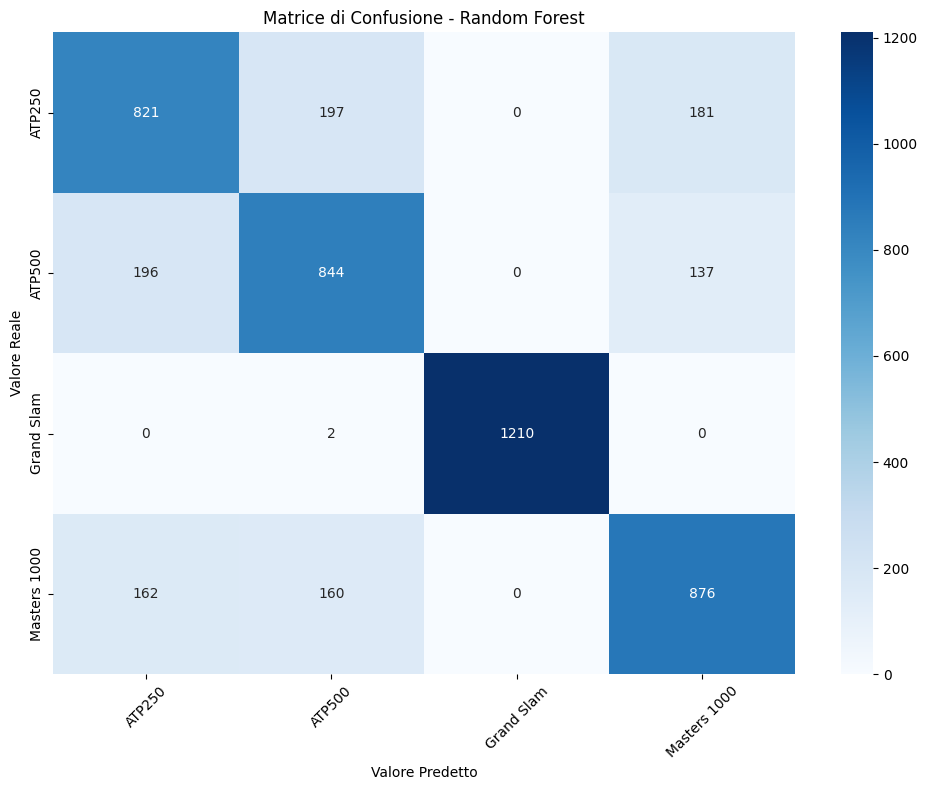

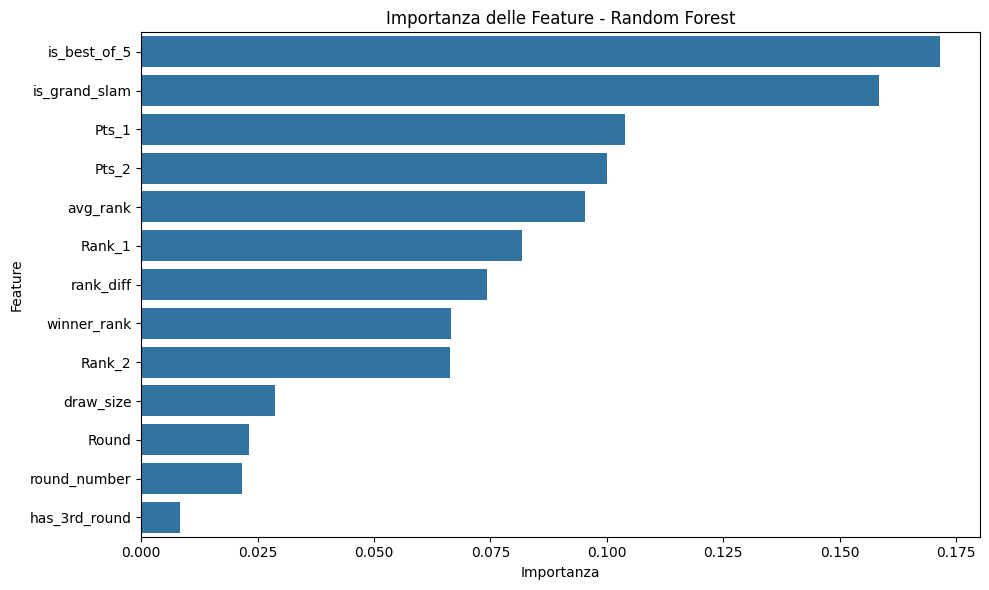


Importanza delle feature in percentuale:
is_best_of_5: 17.16%
is_grand_slam: 15.85%
Pts_1: 10.38%
Pts_2: 10.00%
avg_rank: 9.52%
Rank_1: 8.18%
rank_diff: 7.43%
winner_rank: 6.65%
Rank_2: 6.63%
draw_size: 2.88%
Round: 2.32%
round_number: 2.17%
has_3rd_round: 0.82%

--------------------------------------------------
Valutazione del classificatore: SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      1199
           1       0.54      0.29      0.38      1177
           2       1.00      1.00      1.00      1212
           3       0.60      0.61      0.61      1198

    accuracy                           0.67      4786
   macro avg       0.67      0.67      0.66      4786
weighted avg       0.67      0.67      0.66      4786



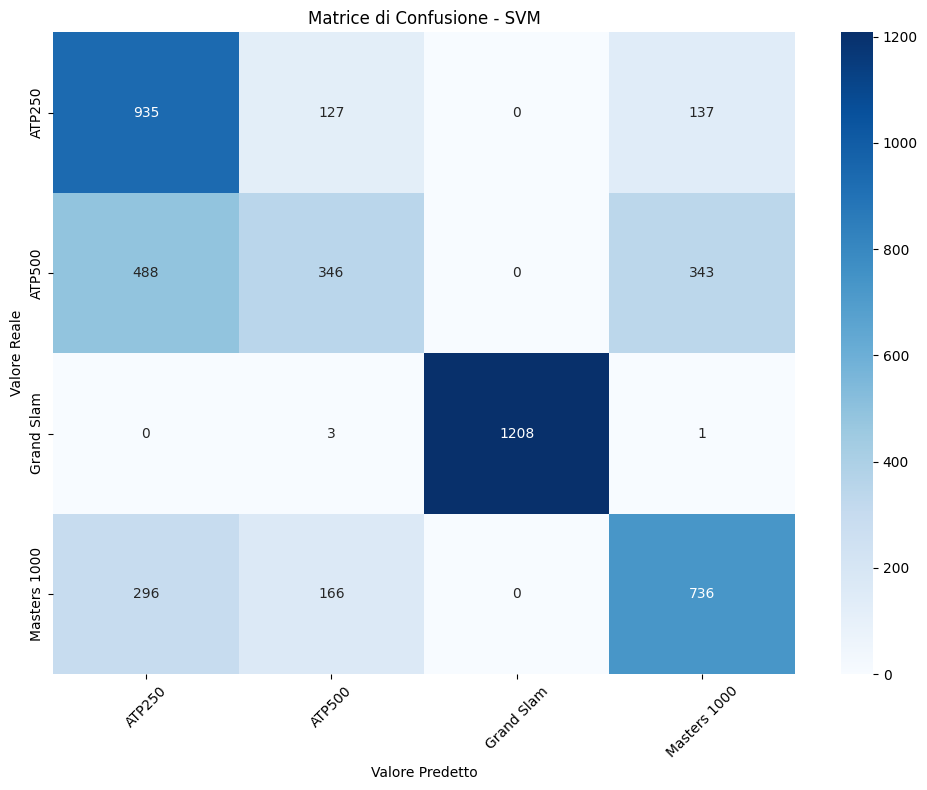


--------------------------------------------------
Valutazione del classificatore: Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.72      0.63      1199
           1       0.50      0.37      0.43      1177
           2       1.00      1.00      1.00      1212
           3       0.62      0.59      0.60      1198

    accuracy                           0.67      4786
   macro avg       0.67      0.67      0.66      4786
weighted avg       0.67      0.67      0.67      4786



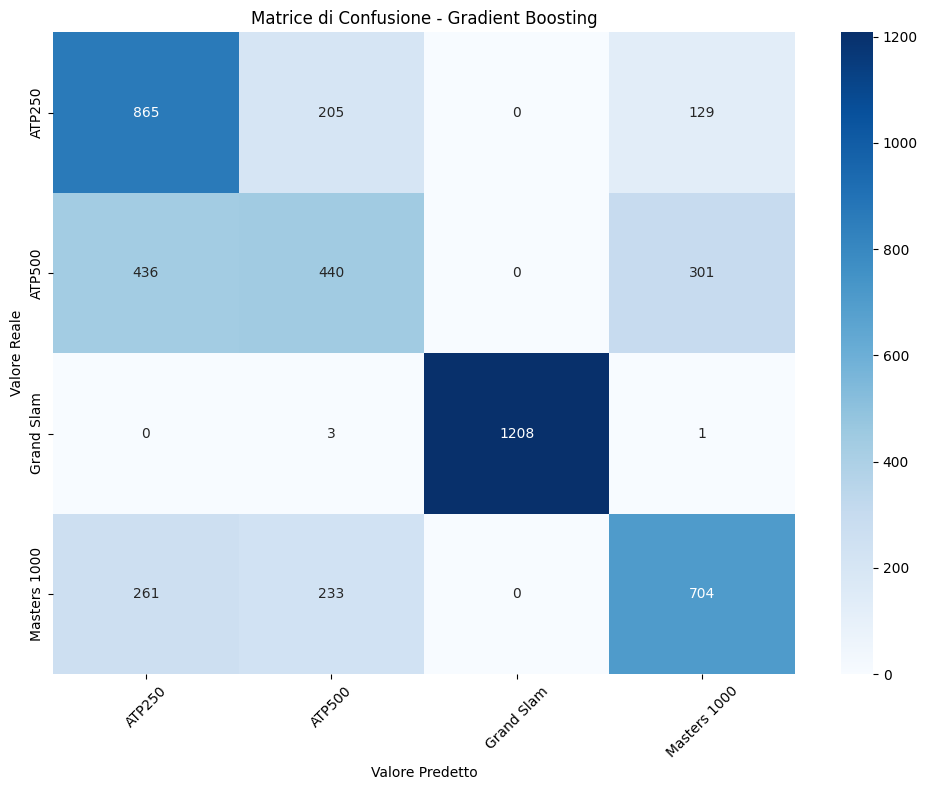

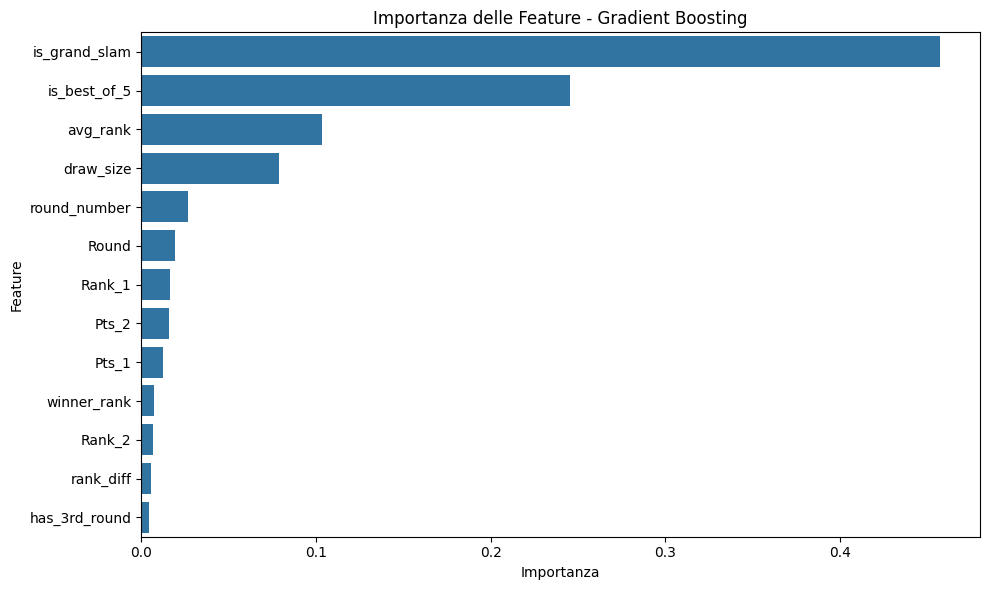


Importanza delle feature in percentuale:
is_grand_slam: 45.72%
is_best_of_5: 24.54%
avg_rank: 10.36%
draw_size: 7.91%
round_number: 2.65%
Round: 1.96%
Rank_1: 1.65%
Pts_2: 1.58%
Pts_1: 1.23%
winner_rank: 0.75%
Rank_2: 0.65%
rank_diff: 0.55%
has_3rd_round: 0.46%


In [161]:
# Dizionario dei classificatori
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Valutazione dei modelli
results = {}

# Dizionario dei classificatori
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(
        kernel='rbf',  # Cambia il kernel
        C=10.0,        # Aumenta C per ridurre la regolarizzazione
        gamma='scale', 
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Assicurati che i dati siano scalati correttamente prima del ciclo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Valutazione dei modelli
results = {}

for name, clf in classifiers.items():
    print(f"\n{'-'*50}")
    print(f"Valutazione del classificatore: {name}")
    
    # Addestramento
    if name == 'SVM':
        # Usa i dati scalati per SVM
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        # Per gli altri classificatori usa i dati originali
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    
    # Salvataggio risultati
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Report di classificazione
    print("\nClassification Report:")
    print(results[name]['classification_report'])
    
    # Matrice di confusione
    plt.figure(figsize=(10, 8))
    cm = results[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f'Matrice di Confusione - {name}')
    plt.ylabel('Valore Reale')
    plt.xlabel('Valore Predetto')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Feature importance per Random Forest e Gradient Boosting
    if name in ['Random Forest', 'Gradient Boosting']:
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': clf.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importance)
        plt.title(f'Importanza delle Feature - {name}')
        plt.xlabel('Importanza')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
        
        print("\nImportanza delle feature in percentuale:")
        for idx, row in feature_importance.iterrows():
            print(f"{row['feature']}: {row['importance']*100:.2f}%")



c:\Users\kikop\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

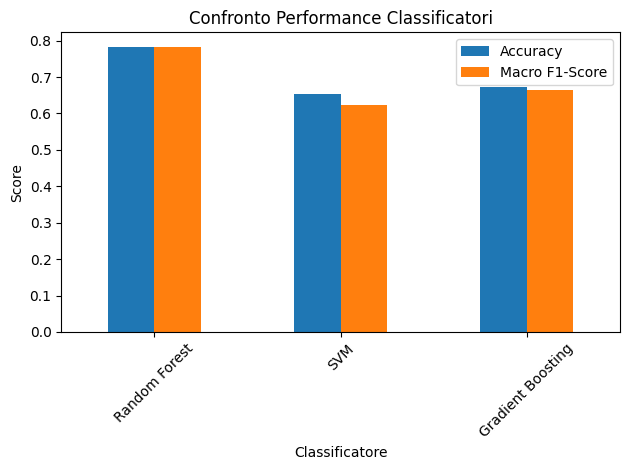


Tabella delle Performance:
   Classificatore  Accuracy  Macro F1-Score
    Random Forest  0.783744        0.782839
              SVM  0.653155        0.624650
Gradient Boosting  0.672169        0.664012


In [162]:
# Confronto delle performance
performances = []
for name, result in results.items():
    report = classification_report(y_test, classifiers[name].predict(X_test), output_dict=True)
    performances.append({
        'Classificatore': name,
        'Accuracy': report['accuracy'],
        'Macro F1-Score': report['macro avg']['f1-score']
    })

# Visualizzazione confronto performance
performance_df = pd.DataFrame(performances)
plt.figure(figsize=(12, 6))
performance_df.plot(x='Classificatore', y=['Accuracy', 'Macro F1-Score'], kind='bar')
plt.title('Confronto Performance Classificatori')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTabella delle Performance:")
print(performance_df.to_string(index=False))